# Setting up the modules 

In [1]:
# common libraries
import sys, glob, random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# analysis related modules
from scipy.stats import entropy, spearmanr
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, GroupKFold
from collections import Counter

In [3]:
# keras modules
import tensorflow as tf
# from keras.models import load_model


from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

# from keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.utils import plot_model
import keras_tqdm
from livelossplot.keras import PlotLossesCallback

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sjnam/anacond

In [54]:
from livelossplot.keras import PlotLossesCallback

In [4]:
# custom layers from external files
from layers.embeddings import ElmoLayer
from layers.attention import AttentionLayer
from models.build_models import build_model_elmo, build_model_elmo_kapelner, initialize_vars
from models.train_models import train_elmomod_cv
from utils.utils import *

In [5]:
# # spacy for tokenizer
# import spacy
# from spacy.tokenizer import Tokenizer
# # from spacy.lang.en import English

In [6]:
# some option settings for Jupyter notebook and TF
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)
tf.logging.set_verbosity(tf.logging.ERROR)

# import dataset 

In [7]:
df_contexts = pd.read_pickle('dataset/predicting_contextual_informativeness-master/kapelner_context.pickle')

In [8]:
df_contexts.tail()

,context_id,context,target_word,band,mean_rating,inappropriate_count,collocation_1_10,collocation_11_20,collocation_21_50,collocation_51_100,...,AWL Sublist 6 Normed,AWL Sublist 7 Normed,AWL Sublist 8 Normed,AWL Sublist 9 Normed,AWL Sublist 10 Normed,All AFL Normed,Core AFL Normed,Spoken AFL Normed,Written AFL Normed,dataset
70494,4120489,"... If the patient is well motivated and given lifelong support, the weight loss is usually permanent. Furthermore, improvement of co-morbid conditions is also well-documented. That said, whether bariatric treatment for morbid obesity is a viable treatment option for more than a small minority of the obese population is open to doubt.",morbid,3,1.90,0,3.0,0.0,0.0,1.0,...,0.028302,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,2
70495,4120507,"... He also believes that guns give their carriers a dangerously false sense of security, and he dislikes the bang they make. His resistance to interrogation is exceptional and he has managed to keep the ""suffix-nine"" designation indicating he is ""reliable under torture"". He has a morbid dislike of dogs, especially guard dogs.",morbid,3,2.33,1,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,2
70496,4120509,"gave a 5 star rating to the movie and noted that ""the beauty of the film lies in its ability to throw light on a morbid subject, compelling the viewer to fall back in love with life."" The review added that the audience would feel ""a Hrithik hangover that stays with you long after you have left the theatre.""",morbid,3,2.50,0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,2
70497,4120511,"... Their strictly tongue-in-cheek humour, often involving executions, murder, necrophilia, resurrections and other morbid topics can be spotted in song titles and album names as well as in their very own mascot - an animated skeleton called ""Ben Wrangle"", the name being a pun on the Swedish word ""benrangel"" which best translates into ""skellington"".",morbid,3,3.13,2,0.0,0.0,0.0,1.0,...,0.000000,0.028169,0.0,0.000000,0.0,0.014085,0.014085,0.0,0.0,2
70498,4120513,"... Gamers could only share IP addresses of known servers between themselves or post them on gaming websites. To solve this problem, a team of three programmers (consisting of Jack ""morbid"" Mathews, Tim Cook, and Joe Powell) formed Spy Software and created QSpy (or QuakeSpy). This allowed the listing and searching of Quake servers available across the internet.",morbid,3,1.70,0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.016129,0.0,0.000000,0.000000,0.0,0.0,2


## sentence inputs

In [9]:
# nlp = spacy.load("en_core_web_lg")

# tokenizer = Tokenizer(nlp.vocab)



# # for doc in tokenizer.pipe(df_contexts['context'][62:63]):
# #     print(doc)

# # spacy lemmatizer does not work with rare words..?
# doc = nlp(u'''... "This is a diversionary tactic by WestJet to draw attention away from evidence filed in court by Air Canada on June 28 including the cross examination of one of WestJet's senior vice presidents, that WestJet surreptitiously and continuously for a ten month period, logged into an Air Canada confidential website using automated technology," Air Canada said in a release.''')
# for token in doc:
#     print(token, token.lemma, token.lemma_)

In [10]:
# some constants
RDM_SEED = 1
K_FOLDS = 10          # in the Kapelner et al.2018 paper: using 10-fold CV, based on target word grouping
# MAX_SEQ_LEN = 20    # determine in the later block, based on the tokenization results
FILTERS = '"#$%&()*+/=@[\\]^_`{|}~\t\n' #'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

In [11]:
context_len = []
for sents in df_contexts['context']:
    context_len.append(len(text_to_word_sequence(sents, lower=False, filters=FILTERS)))
df_contexts['context_len'] = context_len

In [12]:
df_contexts['context_len'].describe()

count    70499.000000
mean     55.511071   
std      3.407092    
min      17.000000   
25%      53.000000   
50%      55.000000   
75%      58.000000   
max      131.000000  
Name: context_len, dtype: float64

## lexical features

In [18]:
col_features = ['similar_1_10', 'collocation_1_10', 'count:target-word1', 'politeness_component', 
                'Kuperman AoA AW', 'Kuperman AoA CW', 'count:word1-target-word2', 'MRC Meaningfulness CW', 
                'num_times_target_exact_match', 'num_acronyms', 'repeated_content_lemmas_pronoun', 'Polit_GI', 
                'prob:word1-target-word2', 'prob:target-word1', 'All AWL Normed',  'MRC Meaningfulness AW', 
                'affect_friends_and_family_component', 'Positive_EmoLex', 'count:target', 'num_times_target_stem_match', 
                'SUBTLEXus Freq AW', 'Econ_GI', 'prob:word1-word2-target', 'BNC Written Bigram Proportion',
                'Arousal_nwords', 'SUBTLEXus Range CW Log', 'BNC Written Trigram Proportion', 'disjunctions',
                'Arousal', 'Brown Freq CW Log']

## consolidate

In [19]:
MAX_SEQ_LEN = 131
CUT_SEQ_LEN = 20

In [149]:
_err_sent_idx = []
def proc_sentences(df, col_sentence, col_targ, col_features, cut_sentence=True, incld_targ=False):
    max_seq_len = MAX_SEQ_LEN
    sentences = []
    li_mask_cntx = []
    li_mask_targ = []
    li_sent_len = []
    li_sent_pad = []
#     li_sent_scr = []
    li_targ = []
    li_feat = []
    for i in range(df.shape[0]):
        sent = df.iloc[i][col_sentence]
#         score = df.iloc[i][col_score]
        feat = df.iloc[i][col_features].values
        targ = df.iloc[i][col_targ]
        
        sent = sent.replace("______", targ)
        sent = sent.replace("<BOS>", "").replace(".", " .").replace(",", " ,").replace("!", " !").replace("?", " ?").replace("'s", " 's")

        sent_tok = text_to_word_sequence(sent, lower=False, filters=FILTERS)
        try: 
            temp_targ_idx = np.where(targ==np.array(sent_tok))[0][0]
            if(cut_sentence):
                sent_tok = sent_tok[np.max([0, temp_targ_idx-CUT_SEQ_LEN]):np.min([len(sent_tok), CUT_SEQ_LEN+temp_targ_idx])]
    #             print(temp_targ_idx, CUT_SEQ_LEN, np.min([0, temp_targ_idx-CUT_SEQ_LEN]), np.min([len(sent_tok), CUT_SEQ_LEN+temp_targ_idx]))
                max_seq_len = CUT_SEQ_LEN*2
            sent_pad = pad_sequences([sent_tok], maxlen=max_seq_len, dtype='object', padding='post', value=[""])

            targ_idx = np.where(targ==sent_pad[0])[0][0] # TODO: the target word in some contexts are mophologically changed/extended as compound words

            if(not incld_targ):
                sent_pad[0][targ_idx] = "<UNK>"

            mask_targ = [0]*(max_seq_len)
            mask_targ[targ_idx] = 1
            mask_cntx = [0]*(max_seq_len)

    #         print(temp_targ_idx, targ_idx+1, len(sent_tok), len(mask_cntx), sent_tok)
            for i in range(targ_idx):
                mask_cntx[i] = 1
            if(incld_targ):
                for i in range(targ_idx, len(sent_tok)):
                    mask_cntx[i] = 1
            else:
                for i in range(targ_idx+1, len(sent_tok)):
                    mask_cntx[i] = 1

            sent_len = len(sent_tok)

            li_sent_len.append(sent_len)
            li_sent_pad.append(list(sent_pad)[0])
            li_mask_cntx.append(mask_cntx)
            li_mask_targ.append(mask_targ)
            li_feat.append(feat)

#             li_sent_scr.append(score)        
            li_targ.append(targ)
#             print(sent, targ, sent_pad)
        except:
#             print(sent, targ, sent_pad)
            _err_sent_idx.append(i)
    sentences = [np.array(li_sent_len), np.array(li_sent_pad), np.array(li_mask_cntx), np.array(li_mask_targ), np.array(li_feat)]
    return(sentences, li_targ)

In [150]:
sentences_notarg, targets = proc_sentences(df_contexts, 'context', 'target_word', col_features,
                                                        cut_sentence=True, incld_targ=False)

In [206]:
# mm_scaler = MinMaxScaler()
# info_scores = mm_scaler.fit_transform(df_contexts[['mean_rating']])
# info_scores = info_scores[:,0]
info_scores = df_contexts['mean_rating'].values

In [207]:
info_scores

array([2.7 , 2.67, 2.1 , ..., 2.5 , 3.13, 1.7 ])

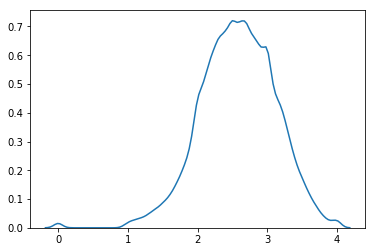

In [208]:
sns.kdeplot(info_scores)

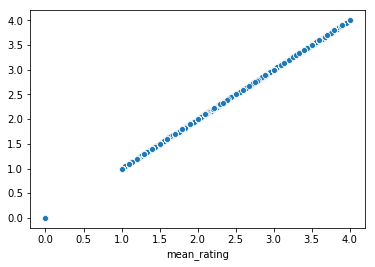

In [209]:
sns.scatterplot(df_contexts['mean_rating'], info_scores)

In [155]:
len(_err_sent_idx)

1596

In [156]:
len(sentences_notarg[0])

68903

In [157]:
[sent[0] for sent in sentences_notarg]

[40, array(['unlimited', 'untapped', 'potential', 'for', 'the', 'development',
        'of', 'tourism', 'in', 'terms', 'of', 'exotic', 'scenic',
        'natural', 'beauty', ',', 'fascinating', 'wild', 'life', ',',
        '<UNK>', 'climate', 'and', 'mosaic', 'of', 'enchanting',
        'cultures', '.', 'It', 'properly', 'conceived', 'and', 'executed',
        ',', 'it', 'will', 'prove', 'to', 'b', 'of'], dtype=object), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0.0, 0.0, 3268, 0.137055172414, 7.0296296296300005, 8.68470588235,
        294, 460.928571429, 1, 0, 0.120689655172, 0.0172413793103,
        -7.36653544585802, -8.352561873277, 0.103448275862, 346.970588235,
        0.29880344827599997, 0.172413793103, 35146, 1, 328295.982143,
        0.051724

In [210]:
gkf = GroupKFold(n_splits=K_FOLDS)
gkf_split = gkf.split(sentences_notarg[0], groups=targets)

gkf_train_idx = []
gkf_test_idx = []
for train_idx, test_idx in gkf_split:
    gkf_train_idx.append(train_idx)
    gkf_test_idx.append(test_idx)

In [211]:
train_idx0 = gkf_train_idx[0]
test_idx0 = gkf_test_idx[0]

In [212]:
sentences_notarg_train = [sent[train_idx0] for sent in sentences_notarg]
sentences_notarg_test  = [sent[test_idx0] for sent in sentences_notarg]

info_scores_train = np.array(info_scores)[train_idx0]
info_scores_test  = np.array(info_scores)[test_idx0]

In [213]:
sentences_notarg_train, info_scores_train

([array([40, 40, 40, ..., 40, 39, 40]),
  array([['unlimited', 'untapped', 'potential', ..., 'to', 'b', 'of'],
         ['at', 'the', 'height', ..., 'week', '.', '.'],
         ['Self', 'honor', 'is', ..., 'should', 'typically', 'start'],
         ...,
         ['to', 'the', 'movie', ..., 'that', 'the', 'audience'],
         ['.', '.', '.', ..., 'mascot', '-', ''],
         ['or', 'post', 'them', ..., '.', 'This', 'allowed']], dtype=object),
  array([[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 0],
         [1, 1, 1, ..., 1, 1, 1]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]),
  array([[0.0, 0.0, 3268, ..., 0.0, 5.03, 1.02144027526],
         [0.0, 0.0, 57, ..., 0.0151515151515, 5.77, 1.84

In [214]:
len(sentences_notarg_train[0]), len(info_scores_train)

(62006, 62006)

# ELMo + Attention model

## ELMo only

In [215]:
K.clear_session()
sess = tf.Session()

model_elmo = build_model_elmo(CUT_SEQ_LEN*2, finetune_emb=True, attention_layer=True, sep_cntx_targ=False, lr=1e-3)
initialize_vars(sess)

model_elmo.summary()

1024
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sent_len (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_sentence (InputLayer)     [(None, 40)]         0                                            
__________________________________________________________________________________________________
elmo_sent_raw (ElmoLayer)       (None, None, 1024)   4           input_sent_len[0][0]             
                                                                 input_sentence[0][0]             
__________________________________________________________________________________________________
input_tloc (InputLayer)         [(None, 40)]         0                                   

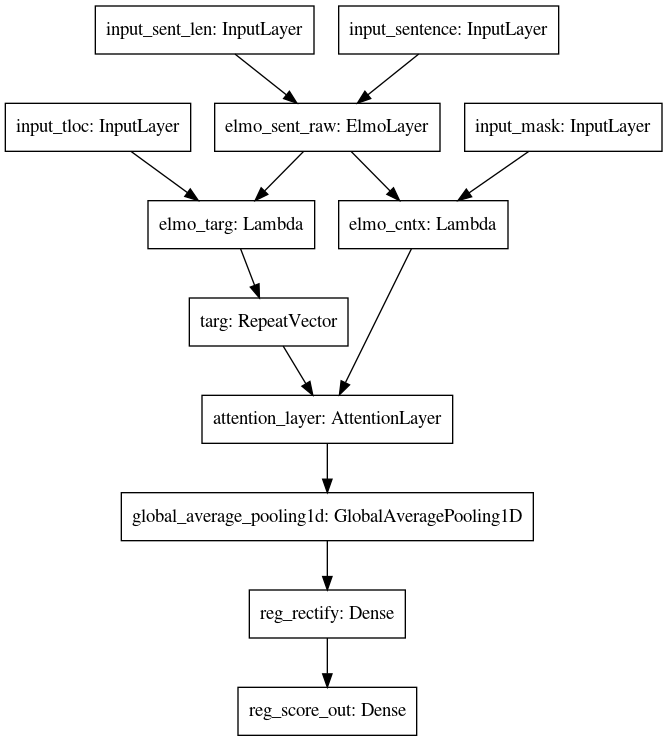

In [216]:
plot_model(model_elmo)

In [217]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13257413413664604004
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2365744286576929303
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10516637287
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9776954781319445717
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 403642374405882137
physical_device_desc: "device: XLA_GPU device"
]


In [218]:
K.eval(model_elmo.optimizer.learning_rate)

0.001

In [219]:
_num_iter = 10
_batch_size = 64

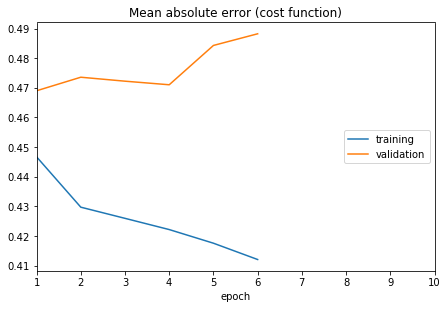

Mean absolute error (cost function):
training   (min:    0.412, max:    0.447, cur:    0.412)
validation (min:    0.469, max:    0.488, cur:    0.488)


KeyboardInterrupt: 

In [220]:
# training
model_elmo.fit(x=sentences_notarg_train, y=info_scores_train, 
         epochs=_num_iter, batch_size=_batch_size, 
         validation_split=0.10, shuffle=True,
         verbose=0, 
         callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=False, leave_outer=True), 
                    plot_losses])

In [221]:
model_elmo.save_weights("./model_weights_kapelner/model_elmo_notarg_wtattn_cut40.h5")

In [222]:
# prediction
pred_test = np.reshape(model_elmo.predict(sentences_notarg_test, batch_size=_batch_size), -1)    
np.save("./model_predict_kapelner/preds_elmo_notarg_wtattn_cut40.npy", pred_test)

In [38]:
gkf = GroupKFold(n_splits=K_FOLDS)
gkf_split = gkf.split(sentences_notarg[0], groups=targets)

fold_idx = 0
for train_idx, test_idx in gkf_split:
    sentences_notarg_train = [sent[train_idx] for sent in sentences_notarg]
    sentences_notarg_test  = [sent[test_idx] for sent in sentences_notarg]

    info_scores_train = np.array(info_scores)[train_idx]
    info_scores_test  = np.array(info_scores)[test_idx]    
    
    K.clear_session()
    sess = tf.Session()
    plot_losses = PlotLossesCallback()

    # preparing
    model_elmo = build_model_elmo(CUT_SEQ_LEN*2, finetune_emb=True, attention_layer=True, sep_cntx_targ=True)
    initialize_vars(sess)
    
    # model training
    model_elmo.fit(x=sentences_notarg_train, y=info_scores_train, 
         epochs=_num_iter, batch_size=_batch_size, 
         validation_split=0.10, shuffle=True,
         verbose=0, 
         callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=False, leave_outer=True), 
                    plot_losses])
    model_elmo.save_weights("./model_weights_kapelner/model_elmo_notarg_wtattn_cut40_cv"+str(fold_idx)+".h5")
    
    # prediction
    pred_test = np.reshape(model_elmo.predict(sentences_notarg_test, batch_size=_batch_size), -1)    
    np.save("./model_predict_kapelner/preds_elmo_notarg_wtattn_cut40_cv"+str(fold_idx)+".npy", pred_test)
    
    fold_idx += 1

In [39]:
train_idx0 = gkf_train_idx[0]
test_idx0 = gkf_test_idx[0]

In [40]:
sentences_notarg_train = [sent[train_idx0] for sent in sentences_notarg]
sentences_notarg_test  = [sent[test_idx0] for sent in sentences_notarg]

info_scores_train = np.array(info_scores)[train_idx0]
info_scores_test  = np.array(info_scores)[test_idx0]

In [69]:
K.clear_session()
sess = tf.Session()
plot_losses = PlotLossesCallback()

# preparing
model_elmo = build_model_elmo(CUT_SEQ_LEN*2, finetune_emb=True, attention_layer=True, sep_cntx_targ=True)
initialize_vars(sess)

1024
1024


## ELMo + lexical features

In [173]:
K.clear_session()
sess = tf.Session()

model_ellx = build_model_elmo_kapelner(MAX_SEQ_LEN, attention_layer=True)
initialize_vars(sess)

model_ellx.summary()

1024
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sent_len (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_sentence (InputLayer)     [(None, 131)]        0                                            
__________________________________________________________________________________________________
elmo_sent (ElmoLayer)           (None, None, 1024)   4           input_sent_len[0][0]             
                                                                 input_sentence[0][0]             
__________________________________________________________________________________________________
input_tloc (InputLayer)         [(None, 131)]        0                                   

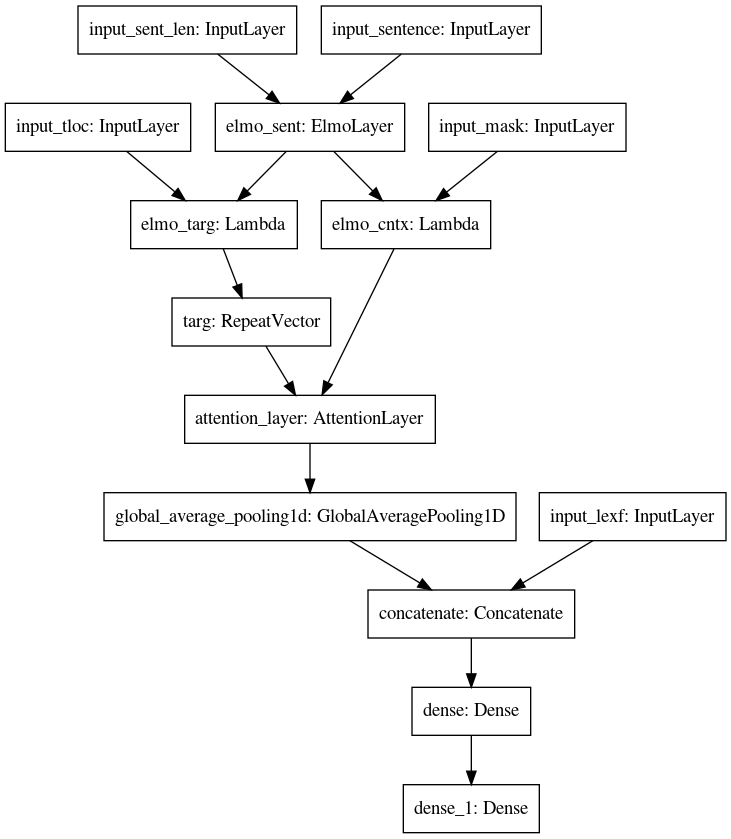

In [174]:
plot_model(model_ellx)

In [175]:
[sent[:1] for sent in sentences_notarg_train]

[array([40]), array([['unlimited', 'untapped', 'potential', 'for', 'the',
         'development', 'of', 'tourism', 'in', 'terms', 'of', 'exotic',
         'scenic', 'natural', 'beauty', ',', 'fascinating', 'wild',
         'life', ',', '<UNK>', 'climate', 'and', 'mosaic', 'of',
         'enchanting', 'cultures', '.', 'It', 'properly', 'conceived',
         'and', 'executed', ',', 'it', 'will', 'prove', 'to', 'b', 'of']],
       dtype=object), array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), array([[0.0, 0.0, 3268, 0.137055172414, 7.0296296296300005,
         8.68470588235, 294, 460.928571429, 1, 0, 0.120689655172,
         0.0172413793103, -7.36653544585802, -8.352561873277,
         0.103448275862, 346.970588235, 0.29880344827599997,
         0.172413793103,

In [110]:
tt_mod = Model(model_ellx.inputs, model_ellx.output) # model_ellx.get_layer('concatenate').output)
tt_w = tt_mod.predict([sent[:3] for sent in sentences_notarg_train])

In [111]:
tt_w

array([[2.5981016],
       [2.5981016],
       [2.5981016]], dtype=float32)

## ELMo + lexical features - cut40

In [176]:
K.clear_session()
sess = tf.Session()
plot_losses = PlotLossesCallback()

# preparing
model_ellx = model_ellx = build_model_elmo_kapelner(CUT_SEQ_LEN*2, attention_layer=True)
initialize_vars(sess)

1024


In [177]:
_num_iter = 10
_batch_size = 64

In [178]:
# model_ellx.load_weights("./model_weights_kapelner/model_ellx_notarg_wtattn.h5")

In [179]:
# training
model_ellx.fit(x=[sent for sent in sentences_notarg_train], y=info_scores_train, 
               epochs=_num_iter, batch_size=_batch_size, 
               validation_split=0.10, shuffle=True,
               verbose=0, 
               callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=False, leave_outer=True), 
                          plot_losses])
model_ellx.save_weights("./model_weights_kapelner/model_ellx_notarg_wtattn_cut40.h5")

KeyboardInterrupt: 

In [206]:
# prediction
pred_test = np.reshape(model_ellx.predict(sentences_notarg_test, batch_size=_batch_size), -1)    
np.save("./model_predict_kapelner/preds_ellx_notarg_wtattn_cut40.npy", pred_test)

# Prediction

## ELMo only

In [58]:
pred_scores = np.load("model_predict_kapelner/preds_elmo_notarg_wtattn.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'model_predict_kapelner/preds_elmo_notarg_wtattn.npy'

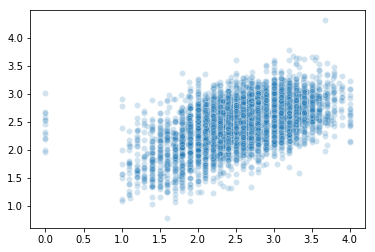

In [272]:
sns.scatterplot(info_scores_test, pred_scores, alpha=0.2)

In [273]:
spearmanr(info_scores_test, pred_scores)

SpearmanrResult(correlation=0.4711249054258521, pvalue=0.0)

In [274]:
r2_score(info_scores_test, pred_scores)

0.19580192387415662

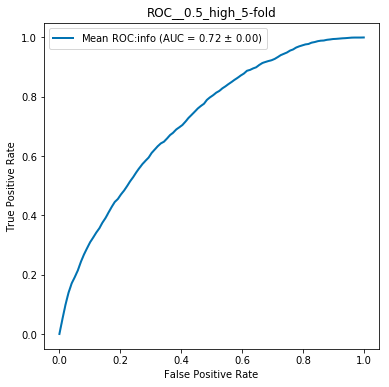

In [256]:
fig, axes = plt.subplots(ncols=1, figsize=(6, 6))
tt_col = sns.color_palette("colorblind", 6)

roc_cv([info_scores_test], "model_predict_kapelner/preds_elmo_notarg_wtattn*", "info", 0.5, "high", fig, axes, tt_col[0], "-")

## ELMo only - cut 40 

In [223]:
pred_scores = np.load("model_predict_kapelner/preds_elmo_notarg_wtattn_cut40.npy")

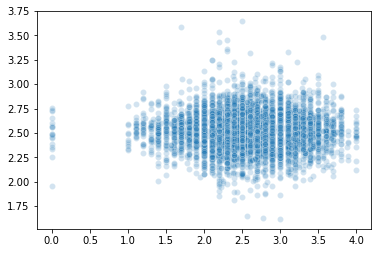

In [224]:
sns.scatterplot(info_scores_test, pred_scores, alpha=0.2)

In [225]:
spearmanr(info_scores_test, pred_scores)

SpearmanrResult(correlation=-0.011966797188299183, pvalue=0.3203805548385458)

In [204]:
r2_score(info_scores_test, pred_scores)

-0.13079756112668206

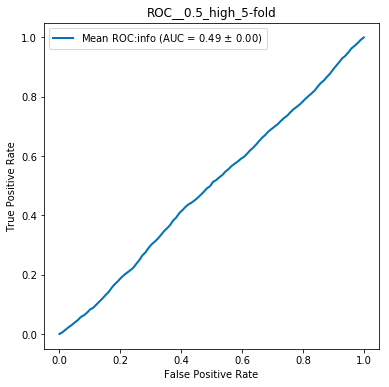

In [205]:
fig, axes = plt.subplots(ncols=1, figsize=(6, 6))
tt_col = sns.color_palette("colorblind", 6)

roc_cv([info_scores_test], "model_predict_kapelner/preds_elmo_notarg_wtattn_cut40*", "info", 0.5, "high", fig, axes, tt_col[0], "-")

## ELMo + lexical features

In [118]:
pred_test = np.load("model_predict_kapelner/preds_ellx_notarg_wtattn.npy")

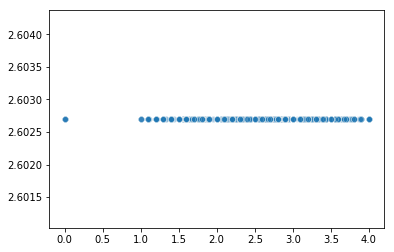

In [119]:
sns.scatterplot(info_scores_test, pred_test, alpha=0.2)

In [120]:
spearmanr(info_scores_test, pred_test)

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


SpearmanrResult(correlation=nan, pvalue=nan)

In [121]:
r2_score(info_scores_test, pred_test)

-1.411675201179463e-07

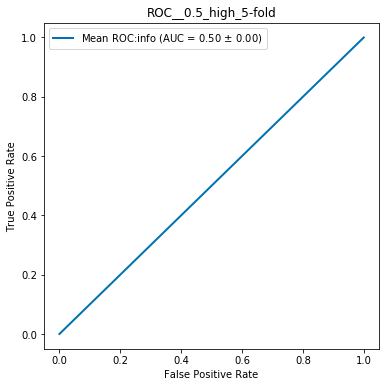

In [122]:
fig, axes = plt.subplots(ncols=1, figsize=(6, 6))
tt_col = sns.color_palette("colorblind", 6)

roc_cv([info_scores_test], "model_predict_kapelner/preds_ellx_notarg_wtattn*", "info", 0.5, "high", fig, axes, tt_col[0], "-")

## ELMo + lexical features - cut40

In [118]:
pred_test = np.load("model_predict_kapelner/preds_ellx_notarg_wtattn_cut40.npy")

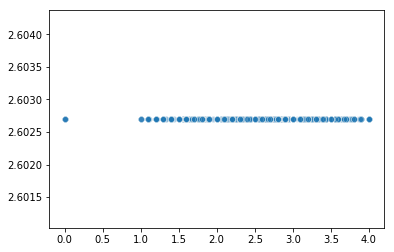

In [119]:
sns.scatterplot(info_scores_test, pred_test, alpha=0.2)

In [120]:
spearmanr(info_scores_test, pred_test)

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


SpearmanrResult(correlation=nan, pvalue=nan)

In [121]:
r2_score(info_scores_test, pred_test)

-1.411675201179463e-07

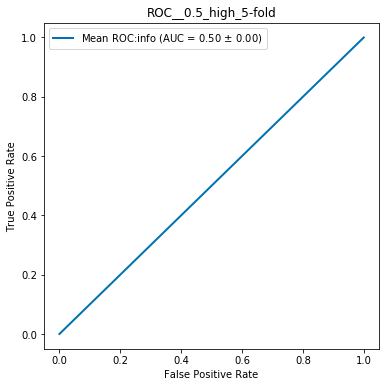

In [122]:
fig, axes = plt.subplots(ncols=1, figsize=(6, 6))
tt_col = sns.color_palette("colorblind", 6)

roc_cv([info_scores_test], "model_predict_kapelner/preds_ellx_notarg_wtattn_cut40*", "info", 0.5, "high", fig, axes, tt_col[0], "-")

# Predicting DSCoVAR sentences with Kapelner et al. model 

In [121]:
import pickle

In [122]:
K.clear_session()
sess = tf.Session()
plot_losses = PlotLossesCallback()

# preparing
model = build_model_elmo(CUT_SEQ_LEN*2, finetune_emb=True, attention_layer=True, sep_cntx_targ=True)
initialize_vars(sess)

1024
1024


In [123]:
model.load_weights("model_weights_kapelner/model_elmo_notarg_wtattn_cut40.h5")

In [124]:
with open("dscovar_sentences_wttarg_elmo_max40.pickle", "rb") as f: sentences_dscovar_notarg = pickle.load(f)
with open("resp_bws.pickle", "rb") as f: resp_bws = pickle.load(f)

In [125]:
pred_scores = np.reshape(model.predict(sentences_dscovar_notarg, batch_size=_batch_size), -1)    
np.save("./model_predict//preds_elmo_kapelner_notarg_wtattn_cut40.npy", pred_scores)

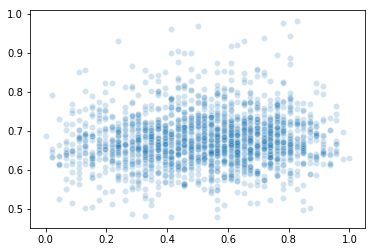

In [126]:
sns.scatterplot(resp_bws, pred_scores, alpha=0.2)

In [127]:
spearmanr(resp_bws, pred_scores)

SpearmanrResult(correlation=0.07802662541286949, pvalue=0.0009757144973439529)

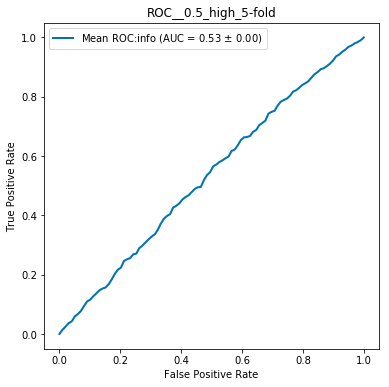

In [128]:
fig, axes = plt.subplots(ncols=1, figsize=(6, 6))
tt_col = sns.color_palette("colorblind", 6)

roc_cv([resp_bws], "./model_predict//preds_elmo_kapelner_notarg_wtattn_cut40*", "info", 0.5, "high", fig, axes, tt_col[0], "-")

# Predicting Kapelner et al. with DSCoVAR model 

In [190]:
K.clear_session()
sess = tf.Session()
plot_losses = PlotLossesCallback()

# preparing
model = build_model_elmo(CUT_SEQ_LEN*2, finetune_emb=True, attention_layer=True, sep_cntx_targ=True)
initialize_vars(sess)

1024
1024


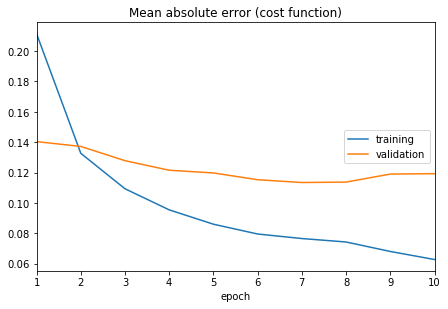

Mean absolute error (cost function):
training   (min:    0.063, max:    0.211, cur:    0.063)
validation (min:    0.113, max:    0.140, cur:    0.119)



In [191]:
# training
model.fit(x=sentences_dscovar_notarg, y=resp_bws, 
         epochs=_num_iter, batch_size=_batch_size, 
         validation_split=0.10, shuffle=True,
         verbose=0, 
         callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=False, leave_outer=True), 
                    plot_losses])
model.save_weights("./model_weights/model_elmo_notarg_wtattn_bws_max40_full.h5")

In [192]:
model.load_weights("./model_weights/model_elmo_notarg_wtattn_bws_max40_full.h5")

In [193]:
pred_scores = model.predict([sent for sent in sentences_notarg], 
                            batch_size=_batch_size, 
                            callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=True, leave_outer=True)])
pred_scores = np.reshape(pred_scores, -1)
np.save("./model_predict_kapelner/preds_elmo_dscovar_notarg_wtattn_cut40.npy", pred_scores)

In [194]:
pred_scores = np.load("./model_predict_kapelner/preds_elmo_dscovar_notarg_wtattn_cut40.npy")

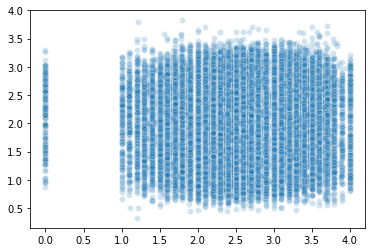

In [195]:
sns.scatterplot(info_scores, pred_scores, alpha=0.2)

In [196]:
spearmanr(info_scores, pred_scores)

SpearmanrResult(correlation=0.06229343386348198, pvalue=3.277419181459985e-60)

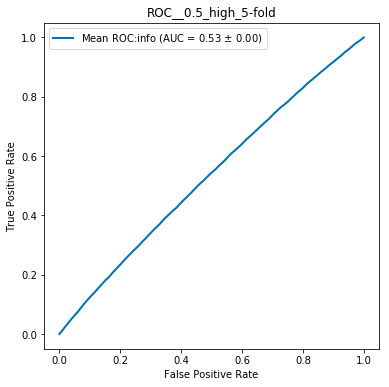

In [197]:
fig, axes = plt.subplots(ncols=1, figsize=(6, 6))
tt_col = sns.color_palette("colorblind", 6)

roc_cv([info_scores], "./model_predict_kapelner/preds_elmo_dscovar_notarg_wtattn_cut40*", "info", 0.5, "high", fig, axes, tt_col[0], "-")